## Identify Fraud from Enron Email
#### Project Overview
In this project, you will play detective, and put your machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

#### Project Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.



In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [64]:
import sys
from time import time
import matplotlib as pl
import matplotlib.pyplot as plt
import pickle

In [65]:
dataPath = '/Users/omojumiller/mycode/MachineLearningNanoDegree/IntroToMachineLearning/'
sys.path.append(dataPath+'tools/')
sys.path.append(dataPath+'final_project/')

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# Optimize Feature Selection/Engineering
## Task 1: Feature selection
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".

The dataset used in this project is store in a Python dictionary created by combining the Enron email and financial data, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

POI label: [‘poi’]

You can take a look at this [enron61702insiderpay.pdf](enron61702insiderpay.pdf) file to get a feel of the data yourself.


In [66]:
features_list = ['poi','salary', 'exercised_stock_options', 'restricted_stock',
                 'from_poi_to_this_person','from_this_person_to_poi'] # You will need to use more features

In [67]:
### Load the dictionary containing the dataset

with open(dataPath+'final_project/final_project_dataset.pkl', "r") as data_file:
    data_dict = pickle.load(data_file)

In [68]:
len(data_dict)

146

## Task 2: Data exploration
- If there are outliers, remove outliers


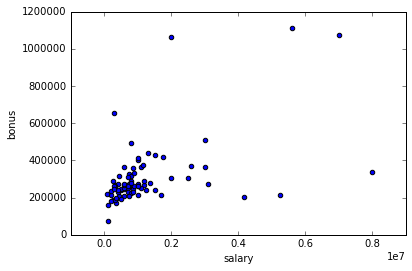

In [90]:
features_list =  [ 'bonus', 'salary']
data = featureFormat(data_dict, features_list, remove_any_zeroes=True)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

1. I need to find out where that outlier is
2. Find out who it is

In [91]:
np.where(data > 0.8 * 1e8) # This is where the outlier is, what I have to do now is find out who it is


(array([], dtype=int64), array([], dtype=int64))

In [78]:
data[57] # So whose salary is 97343619?
# What’s the name of the dictionary key of this data point?

array([ 34348384.,   1072321.])

In [89]:
for key, value in data_dict.iteritems():
    if (value['bonus'] >= int(data[57][1]) and 
        value['bonus'] != "NaN" and
        value['salary'] != "NaN"):
        print "{:30}{:10}${:<10d}{:20}${:<10d}".format(key, 'salary is ', value['salary'],
                                                   ' exercised stock options ', value['exercised_stock_options'])


BAXTER JOHN C                 salary is $267102     exercised stock options $6680544   
ELLIOTT STEVEN                salary is $170941     exercised stock options $4890344   
HANNON KEVIN P                salary is $243293     exercised stock options $5538001   
MCMAHON JEFFREY               salary is $370448     exercised stock options $1104054   
HUMPHREY GENE E               salary is $130724     exercised stock options $2282768   
WALLS JR ROBERT H             salary is $357091     exercised stock options $4346544   
SHANKMAN JEFFREY A            salary is $304110     exercised stock options $1441898   
BIBI PHILIPPE A               salary is $213625     exercised stock options $1465734   
RIEKER PAULA H                salary is $249201     exercised stock options $1635238   
LAVORATO JOHN J               salary is $339288     exercised stock options $4158995   
BERBERIAN DAVID               salary is $216582     exercised stock options $1624396   
DETMERING TIMOTHY J           sa

Found the source of the outlier. It was the total row that was mistakenly read into the data dict

In [73]:
# Remove the source of the outlier
data_dict.pop( 'TOTAL')

# We can now go back and rerun the regression to see what the data really looks like.

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

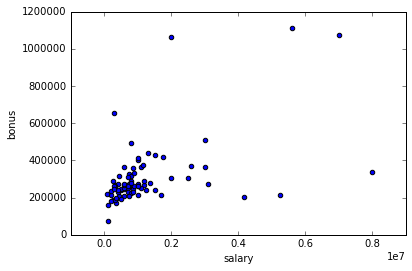

In [74]:
features_list = [ 'bonus', 'salary']
data = featureFormat(data_dict, features_list, remove_any_zeroes=True)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

## PCA

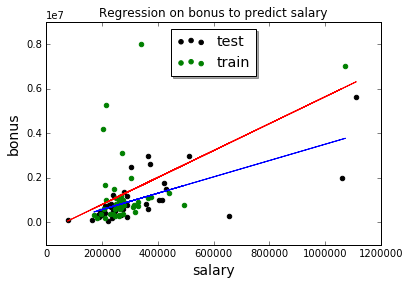

slope of regression is 3.66
intercepts of regression is -153088.50

 ********stats on dataset********

r-squared score on testing data:  0.497975394097
r-squared score on training data:  0.132788195652


In [61]:

features_list = [ 'bonus', 'salary']
data = featureFormat(data_dict, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

from sklearn.cross_validation import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features,
                                                                          target, test_size=0.5, random_state=42)
train_color = "g"
test_color = "k"



### Regression 

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(feature_train, target_train)


### draw the scatterplot, with color-coded training and testing points

for feature, target in zip(feature_test, target_test):
    plt.scatter( feature, target, color=test_color ) 
for feature, target in zip(feature_train, target_train):
    plt.scatter( feature, target, color=train_color ) 

### labels for the legend
plt.scatter(feature_test[0], target_test[0], color=test_color, label="test")
plt.scatter(feature_test[0], target_test[0], color=train_color, label="train")


#plt.xticks(np.arange(0, 1e7, 200000), rotation = -60)
#plt.xlim((0, 1e7))
#plt.ylim((0, 1e7))

### draw the regression line, once it's coded
try:
    plt.plot( feature_test, reg.predict(feature_test), color='r')
except NameError:
    pass

reg.fit(feature_test, target_test)
plt.plot(feature_train, reg.predict(feature_train), color='b')

plt.title('Regression on '+features_list[0]+' to predict '+features_list[1])
plt.xlabel(features_list[1], fontsize=14)
plt.ylabel(features_list[0], fontsize=14)
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

print "slope of regression is %.2f" % reg.coef_
print "intercepts of regression is %.2f" % reg.intercept_

print "\n ********stats on dataset********\n"
print "r-squared score on testing data: ", reg.score(feature_test, target_test)
print "r-squared score on training data: ", reg.score(feature_train, target_train)



- Low r squared value or large SSE indicates high bias, i.e., high error on the training data.

Two people made bonuses of at least 5 million dollars, and a salary of over 1 million dollars; in other words, they made out like bandits.

| Name       | Salary           | Bonus  |
| ------------- |-------------| -----|
| LAY KENNETH L      | 1,072,321.00 | 7,000,000.00 |
| SKILLING JEFFREY K | 1,111,258.00 | 5,600,000.00 |




In [62]:

for key, value in data_dict.iteritems():
    if (value['salary'] != "NaN") and (value['bonus'] != "NaN" and value['bonus'] > 4000000):
        print "{:20}{:12}${:<12,.2f}{:12}${:<12,.2f}".format(key, 'salary is ', 
                                                             value['salary'], ' bonus is ', value['bonus'])


LAVORATO JOHN J     salary is   $339,288.00   bonus is   $8,000,000.00
LAY KENNETH L       salary is   $1,072,321.00 bonus is   $7,000,000.00
BELDEN TIMOTHY N    salary is   $213,999.00   bonus is   $5,249,999.00
SKILLING JEFFREY K  salary is   $1,111,258.00 bonus is   $5,600,000.00
ALLEN PHILLIP K     salary is   $201,955.00   bonus is   $4,175,000.00


## Task 3: Create new feature(s)
- Store to `my_dataset` for easy export below.

In [ ]:
my_dataset = data_dict

Extract features and labels from dataset for local testing

In [ ]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Pick and Tune an Algorithm
## Task 4: Try a variety of classifiers
- Please name your classifier clf for easy export below.
- Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Validate and Evaluate
## Task 5: Tune your classifier
- Achieve better than .3 precision and recall. Using our testing script. Check the `tester.py` script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses `stratified shuffle split cross validation`. For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


In [ ]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

## Task 6: Export solution
Dump your classifier, dataset, and features_list so anyone can check your results. You do not need to change anything below, but make sure that the version of `poi_id.py` that you submit can be run on its own and generates the necessary .pkl files for validating your results.

In [ ]:
dump_classifier_and_data(clf, my_dataset, features_list)

In [ ]:
"""
    Starter code for the regression mini-project.
    
    Loads up/formats a modified version of the dataset
    (why modified?  we've removed some trouble points
    that you'll find yourself in the outliers mini-project).

    Draws a little scatterplot of the training/testing data

    You fill in the regression code where indicated:
"""    


from feature_format import featureFormat, targetFeatureSplit
dictionary = pickle.load( open(dataPath+'/final_project/final_project_dataset_modified.pkl', "r") )

### list the features you want to look at--first item in the 
### list will be the "target" feature

print "\n ********Regression on salary to predict bonus ********\n"

features_list = ["bonus", "salary"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

### training-testing split needed in regression, just like classification
from sklearn.cross_validation import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features, 
                                            target, test_size=0.5, random_state=42)
train_color = "b"
test_color = "r"



### Your regression goes here!
### Please name it reg, so that the plotting code below picks it up and 
### plots it correctly. Don't forget to change the test_color above from "b" to
### "r" to differentiate training points from test points.

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(feature_train, target_train)


### draw the scatterplot, with color-coded training and testing points
import matplotlib.pyplot as plt
for feature, target in zip(feature_test, target_test):
    plt.scatter( feature, target, color=test_color ) 
for feature, target in zip(feature_train, target_train):
    plt.scatter( feature, target, color=train_color ) 

### labels for the legend
plt.scatter(feature_test[0], target_test[0], color=test_color, label="test")
plt.scatter(feature_test[0], target_test[0], color=train_color, label="train")




### draw the regression line, once it's coded
try:
    plt.plot( feature_test, reg.predict(feature_test) )
except NameError:
    pass


plt.xlabel(features_list[1])
plt.ylabel(features_list[0])
plt.legend()
plt.show()

print "slope of regression is %.2f" % reg.coef_
print "intercepts of regression is %.2f" % reg.intercept_

print "\n ********stats on dataset********\n"
print "r-squared score on testing data: ", reg.score(feature_test, target_test)
print "r-squared score on training data: ", reg.score(feature_train, target_train)



An r-squared score of -1.48499241737 is pretty bad. 

There are lots of finance features available, some of which might be more powerful than others in terms of predicting a person’s bonus. For example, suppose you thought about the data a bit and guess that the ```long_term_incentive``` feature, which is supposed to reward employees for contributing to the long-term health of the company, might be more closely related to a person’s bonus than their salary is.

A way to confirm that you’re right in this hypothesis is to regress the bonus against the long term incentive, and see if the regression score is significantly higher than regressing the bonus against the salary. **Perform the regression of bonus against long term incentive--what’s the score on the test data?**



In [ ]:
print "\n ********Regression on long_term_incentive to predict bonus ********\n"


features_list = ["bonus", "long_term_incentive"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

### training-testing split needed in regression, just like classification
from sklearn.cross_validation import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, test_size=0.5, random_state=42)
train_color = "b"
test_color = "r"


from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(feature_train, target_train)



### draw the scatterplot, with color-coded training and testing points
import matplotlib.pyplot as plt
for feature, target in zip(feature_test, target_test):
    plt.scatter( feature, target, color=test_color ) 
for feature, target in zip(feature_train, target_train):
    plt.scatter( feature, target, color=train_color ) 

### labels for the legend
plt.scatter(feature_test[0], target_test[0], color=test_color, label="test")
plt.scatter(feature_test[0], target_test[0], color=train_color, label="train")




### draw the regression line, once it's coded
try:
    plt.plot( feature_test, reg.predict(feature_test) )
except NameError:
    pass
plt.xlabel(features_list[1])
plt.ylabel(features_list[0])
plt.legend()
plt.show()

print "slope of regression is %.2f" % reg.coef_
print "intercepts of regression is %.2f" % reg.intercept_

print "\n ********stats on dataset********\n"
print "r-squared score on testing data: ", reg.score(feature_test, target_test)
print "r-squared score on training data: ", reg.score(feature_train, target_train)

**Go back to a setup where you are using the salary to predict the bonus, and rerun the code to remind yourself of what the data look like.** You might notice a few data points that fall outside the main trend, someone who gets a high salary (over a million dollars!) but a relatively small bonus. This is an example of an outlier, and we’ll spend lots of time on them in the next lesson.

A point like this can have a big effect on a regression: if it falls in the training set, it can have a significant effect on the slope/intercept if it falls in the test set, it can make the score much lower than it would otherwise be as things stand right now, this point falls into the test set (and probably hurting the score on our test data as a result). Let’s add a little hack to see what happens if it falls in the training set instead. Add these two lines near the bottom right before ```plt.xlabel(features_list[1]):```

```python
reg.fit(feature_test, target_test)
plt.plot(feature_train, reg.predict(feature_train), color="b")
```

Now we’ll be drawing two regression lines, one fit on the test data (with outlier) and one fit on the training data (no outlier). Look at the plot now--big difference, huh? That single outlier is driving most of the difference. **What’s the slope of the new regression line?**

(That’s a big difference, and it’s mostly driven by the outliers.)

In [ ]:

from feature_format import featureFormat, targetFeatureSplit
dictionary = pickle.load( open(dataPath+'/final_project/final_project_dataset_modified.pkl', "r") )

### list the features you want to look at--first item in the 
### list will be the "target" feature

print "\n ********Regression on salary to predict bonus, cleaned for Outliers ********\n"

features_list = ["bonus", "salary"]
data = featureFormat( dictionary, features_list, remove_any_zeroes=True)
target, features = targetFeatureSplit( data )

### training-testing split needed in regression, just like classification
from sklearn.cross_validation import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, test_size=0.5, random_state=42)
train_color = "b"
test_color = "r"



### Your regression goes here!
### Please name it reg, so that the plotting code below picks it up and 
### plots it correctly. Don't forget to change the test_color above from "b" to
### "r" to differentiate training points from test points.

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(feature_train, target_train)


### draw the scatterplot, with color-coded training and testing points
import matplotlib.pyplot as plt
for feature, target in zip(feature_test, target_test):
    plt.scatter( feature, target, color=test_color ) 
for feature, target in zip(feature_train, target_train):
    plt.scatter( feature, target, color=train_color ) 

### labels for the legend
plt.scatter(feature_test[0], target_test[0], color=test_color, label="test")
plt.scatter(feature_test[0], target_test[0], color=train_color, label="train")


### draw the regression line, once it's coded
try:
    plt.plot( feature_test, reg.predict(feature_test) )
except NameError:
    pass

reg.fit(feature_test, target_test)
plt.plot(feature_train, reg.predict(feature_train), color="b") 

plt.xlabel(features_list[1])
plt.ylabel(features_list[0])
plt.legend()
plt.show()

print "slope of regression is %.2f" % reg.coef_
print "intercepts of regression is %.2f" % reg.intercept_

print "\n ********stats on dataset********\n"
print "r-squared score on testing data: ", reg.score(feature_test, target_test)
print "r-squared score on training data: ", reg.score(feature_train, target_train)
